# Mission Let's Hack Cancer - submission

### Isabela Figueira

December 2019


## Introduction

I first create my leave-one-out method and explain the process that led me to my chosen comparison metric for sensitivity. My final method uses no wrappers for complex algorithms! Everything is coded inline.

I then include some comparisons between multiclass classification methods that I used for my UCI machine learning course.

I will include a separate file with the final algorithm that accepts one sample as its input as part of my submission.

---
## Import and Preprocess the data

First, I import the data from a "data" folder in the directory of my code. I then merge the two csv file contents by patient id and separate the labels from the features in the data. These become my y and x datasets respectively.

In [2]:
import numpy as np
import pandas as pd

import sklearn
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
#from sklearn.metrics import accuracy_score

#from scipy.spatial.distance import euclidean
from scipy.spatial import minkowski_distance

from sklearn import tree
import graphviz 
from sklearn.ensemble import RandomForestClassifier


In [3]:
#import the data into pandas dataframes
df_clinical = pd.read_csv("datasets/clinical.csv") 
#print(df_clinical)
df_RNA = pd.read_csv("datasets/miRNA_counts.csv") 
#print(df_RNA)

In [4]:
#merge the two dataframes on the patient id. one of the sets has slightly more patients, so that will get cut
merged_inner = pd.merge(left=df_clinical,right=df_RNA, left_on='patient_id', right_on='patient_id')

#get the target values out
#remove the clinical data. we just used the clinical data to match the patient ids and remove stragglers 
#drop the patient id as well

#the miRNA data
total_data = merged_inner.drop(['patient_id','gender', 'year_of_birth', 'race', 'vital_status', 'ethnicity',
                   'year_of_diagnosis', 'primary_diagnosis', 'tumor_stage',
                   'age_at_diagnosis', 'prior_treatment', 'tissue_or_organ_of_origin',
                   'prior_malignancy', 'ajcc_pathologic_stage',
                   'site_of_resection_or_biopsy', 'treatment_type',
                   'treatment_or_therapy'], axis=1)

# shuffle the data for future machine learning
shuffled = total_data.sample(frac=1)

# The frac keyword argument specifies the fraction of rows to return in the random sample,
# so frac=1 means return all rows (in random order)

y_data = shuffled['cancer']

x_data = shuffled.drop('cancer',axis=1)

print(total_data.shape)
print(x_data.shape)
print(y_data.shape)

(2501, 1882)
(2501, 1881)
(2501,)


---
## Leave one out methods

First, I will attempt some leave-one-out methods to do vector comparisons

The first one I tried is a naive, leave-one-out algorithm in which I separate one row from the rest and iteratively compare the row to each sample using a distance metric. I begin by using Euclidean distance, since this is a common metric for distance between points.

This algorithm is incredibly slow, so I kept the example here short (only 20 iterations), and I attempt a matrix version underneath. 

We begin with the Minkowski distance between two vectors is defined as $ (\sum_{i=1}^{n} |X_i - Y_i|^p)^\frac{1}{p} $, with p >= 1. This equation is a generalization of Euclidean distance (p=2 and aka the L2 norm) and Manhattan distance (p=1 and aka the L1 norm). Euclidean distance, where p=2, refers to the straight line distance between two points in space. The Manhattan distance, where p=1, is referred to as city block distance or the taxi-cab distance since it counts the distance needed to "drive" from one point to another around corners or blocks and not straight through the blocks.

In [162]:
#trying a leave one out pattern match
#if it's a match, the true value should match the first cancer in the list of probabilities outputed.

#will use sensitivity, which is the "true positive" (tp) rate
def leave_out_super_slow():
    count_tp = 0
    #n = 2501
    n = 20
    for i in range(0,n):
        #split current row from the rest
        x_current = x_data.iloc[[i]]
        x_rest = x_data.drop(x_data.index[i])
        y_current_df = y_data.iloc[[i]]    
        y_rest_df = y_data.drop(y_data.index[i])
        y_current = list(y_current_df)[0]

        #track the probabilities
        probs = { "lung": -1, "prostate":-1, "endometrial":-1,"colorectal":-1,"kidney":-1   }
        #print(list(y_current)[0])

        #print("predict:")
        for j in range(0,len(x_rest)):
            y_rest = list(y_rest_df.iloc[[j]])[0]
            distance = minkowski_distance(x_current,x_rest.iloc[[j]], 2)
            if probs[y_rest] == -1:
                probs[y_rest] = distance
            elif distance < probs[y_rest]:
                probs[y_rest] = distance
        #print(probs)
        minkey = min(probs.keys(), key=(lambda k: probs[k]))

        #sort the probabilities by smallest to largest and only print out the top 3 likeliest 
        #p_view = [ (v,k) for k,v in probs.items() ]
        #p_view.sort(reverse=False) #sort tuples by first element
        #for v,k in p_view[0:3]:
            #print("\t%s: %d" % (k,v))

        #print("Predicted y: %s" % minkey)
        if y_current == minkey:
            #print("correct prediction %s, %s" % (y_current, minkey))
            count_tp += 1        
        #print()

    print(count_tp)
    print("Accuracy: %f" % float(count_tp/n))    

#leave_out_super_slow()

20
Accuracy: 1.000000


#### Faster algorithm!

In the next algorithm, we score how many times the 1 diagnosed disease for each sample matches its true clinical label. 

This version of the algorithm is much faster since I use matrices. When I separate one row from the rest, I duplicate it into a matrix of the size of the rest, and I originally used the scipy function "minkowski_distance" to find the distances between the rows of the two matrices. But then I switched to using the direct formulas for distance since I wanted more control. I will explain more after I show some results.

In [5]:
# Try a more efficient method using matrices
# more efficient than a generic for loop!

xdata = np.array(x_data)
ydata = np.array(y_data)

def leave_one_out_pattern(p=1):
    print("p = %f" % p)
    
    count_tp = 0

    n = len(xdata)
    n_less = n - 1
    for i in range(0,n):
        #split current row from the rest
        x_current = xdata[i]
        x_rest = np.delete(xdata, i, 0)
        y_current = ydata[i] 
        y_rest = np.delete(ydata, i, 0)

        #distances = minkowski_distance(np.tile(x_current, (n_less,1)), x_rest, p)
        #instead of doing this, we will use the direct formula:
        
        if p == 1:
            distances = np.sum(np.abs(np.tile(x_current, (n_less,1)) - x_rest), axis=-1) 
            #this is the function that is inside the minkowski_distance_p function in scipy 
        elif p < 1:
            distances = np.sum(np.abs(np.tile(x_current, (n_less,1)) - x_rest)**p, axis=-1)
        elif p > 1:
            distances = np.sum(np.abs(np.tile(x_current, (n_less,1)) - x_rest)**p, axis=-1)**(1./p)

        min_index = np.argmin(distances, axis=0)

        if y_current == y_rest[min_index]:
            #print("correct prediction: %s vs %s" % (y_current, y_rest[min_index]))
            count_tp += 1

        #print(distances)

    #print("accuracy is number of correct predictions out of total %d/%d" % (count_tp,n))
    accuracy = float(count_tp/n)
    print("Accuracy: %f" % accuracy)
    return accuracy

p = 0.300000
Accuracy: 0.984006
p = 0.400000
Accuracy: 0.989604
p = 0.500000
Accuracy: 0.989204
p = 1.000000
Accuracy: 0.976010
p = 2.000000
Accuracy: 0.956417
p = 3.000000
Accuracy: 0.953219


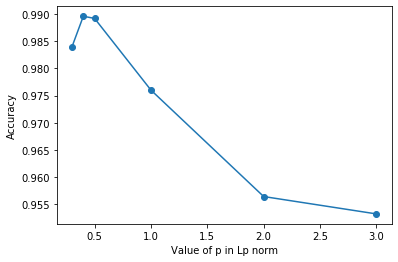

In [118]:
p_s = [0.3,0.4,0.5,1,2,3]
all_accs = []
for p in p_s:
    all_accs.append(leave_one_out_pattern(p))
    
plt.plot(p_s, all_accs, marker='o')
plt.xlabel("Value of p in Lp norm")
plt.ylabel("Accuracy")
plt.show()

With these results we can see that p=0.4 gave us the best accuracy of all of the p's. However, the definition of Minkowski distance stated that this norm was only a metric if p >= 1, since values in the range \(0,1) violate the triangle inequality, making them invalid. They can still technically be used, although invalid.

Just to make sure we are in the clear, I make it into a metric by removing the exponent of 1/p. This resulting metric is also an F-norm. 


To handle this, in the script above, I no longer use the scipy function "minkowski_distance", since this requires the exponent of 1/p in the equation.[^1] I instead use the direct formulas:

```Python
        if p == 1:
            distances = np.sum(np.abs(np.tile(x_current, (n_less,1)) - x_rest), axis=-1) 
            #this is the function that is inside the minkowski_distance_p function in scipy for p=1
        elif p < 1:
            distances = np.sum(np.abs(np.tile(x_current, (n_less,1)) - x_rest)**p, axis=-1)
            #with p < 1, we don't use the exponent (1./p) on the outside of the sum. this makes it an f-norm.
        elif p > 1:
            distances = np.sum(np.abs(np.tile(x_current, (n_less,1)) - x_rest)**p, axis=-1)**(1./p)
            #if p > 1, then we use the regular Minksowski distance equation
```



Using distance metrics with p <= 1 gave a higher accuracy than Euclidean distance (p=2). Since the data is of a  high dimension, it is difficult to determine why this is the case. Perhaps it is due to the "curse of dimensionality": when the dimension of data gets too large, all the points are similarly close together making spatial distance metrics like Euclidean distance no longer meaningful. In situations with high dimensional data, Manhattan distance performs better than Euclidean. [^2]

However, on further investigation, large dimensions are said to be in the thousands, 6000 for example. [^3] Our dataset is not that large. But perhaps our dataset similarly performs better with smaller exponents since decreasing the exponent makes other features play a larger role in the distance calculation. 


The best accuracy occurs with p=0.4. So, we stick with that in the next sections.



[^1]:https://github.com/scipy/scipy/blob/v1.3.3/scipy/spatial/kdtree.py#L15-L46
[^2]: https://bib.dbvis.de/uploadedFiles/155.pdf
[^3]: http://www.stat.ucla.edu/~sabatti/statarray/textr/node5.html

#### We now test the performance of the system by the following terms:

* Score how many times the #1 diagnosed disease for each sample matches its true clinical label by this definition.
* Score how many times the #1 or #2 diagnosed disease for each sample matches its true clinical label, and provide the total % of samples that were correctly diagnosed by this definition.
* Score how many times the #1,#2 or #3 diagnosed disease for each sample matches its true clinical label, and provide the total % of samples that were correctly diagnosed by this definition.

In [12]:
xdata = np.array(x_data)
ydata = np.array(y_data)

def leave_one_out_multiple_definitions(p=1):
    count_1 = 0
    count_2 = 0
    count_3 = 0

    n = len(xdata)
    n_less = n - 1
    for i in range(0,n):
        #split current row from the rest
        x_current = xdata[i]
        x_rest = np.delete(xdata, i, 0)
        y_current = ydata[i] 
        y_rest = np.delete(ydata, i, 0)

        #distances = minkowski_distance(np.tile(x_current, (n_less,1)), x_rest, p)
        
        if p == 1:
            distances = np.sum(np.abs(np.tile(x_current, (n_less,1)) - x_rest), axis=-1) 
            #this is the function that is inside the minkowski_distance_p function in scipy 
        elif p < 1:
            distances = np.sum(np.abs(np.tile(x_current, (n_less,1)) - x_rest)**p, axis=-1)
        elif p > 1:
            distances = np.sum(np.abs(np.tile(x_current, (n_less,1)) - x_rest)**p, axis=-1)**(1./p)

        #min_index = np.argmin(distances, axis=0)
        mins = np.argsort(distances)
        #now get the labels and find the smallest of each kind of cancer
        
        probs = [y_rest[mins[0]]]
        j = 1
        while len(probs) < 5:
            if y_rest[mins[j]] not in probs:
                probs.append(y_rest[mins[j]])
            j += 1
        
        if y_current == probs[0]:
            count_1 += 1
        elif y_current == probs[1]:
            count_2 += 1
        elif y_current == probs[2]:
            count_3 += 1
            
        #print(probs)

    print("Definitions of classification")
    print("Score of how many times the #1 diagnosed disease for each sample matches its true clinical label")
    print("Accuracy = %d/%d = %f" % (count_1, n, float(count_1/n)))
    
    print("Score of how many times the #1 or #2 diagnosed disease for each sample matches its true clinical label")
    print("Accuracy = (%d + %d)/%d = %f" % (count_1, count_2, n, float((count_1 + count_2)/n)))
    
    print("Score of how many times the #1,#2 or #3 diagnosed disease for each sample matches its true clinical label")
    print("Accuracy = (%d + %d + %d)/%d = %f" % (count_1, count_2, count_3, n, float((count_1 + count_2 + count_3)/n)))
    
    return [float(count_1/n),float((count_1 + count_2)/n),float((count_1 + count_2 + count_3)/n)]

In [203]:
print("Manhattan")
leave_one_out_multiple_definitions(1) #Manhattan distance
print()
print("Euclidean")
leave_one_out_multiple_definitions(2) #Euclidean distance
print()
print("p=0.4")
leave_one_out_multiple_definitions(0.4)

Manhattan
Definitions of classification
Score of how many times the #1 diagnosed disease for each sample matches its true clinical label
Accuracy = 2441/2501 = 0.976010
Score of how many times the #1 or #2 diagnosed disease for each sample matches its true clinical label
Accuracy = (2441 + 43)/2501 = 0.993203
Score of how many times the #1,#2 or #3 diagnosed disease for each sample matches its true clinical label
Accuracy = (2441 + 43 + 8)/2501 = 0.996401

Euclidean
Definitions of classification
Score of how many times the #1 diagnosed disease for each sample matches its true clinical label
Accuracy = 2392/2501 = 0.956417
Score of how many times the #1 or #2 diagnosed disease for each sample matches its true clinical label
Accuracy = (2392 + 73)/2501 = 0.985606
Score of how many times the #1,#2 or #3 diagnosed disease for each sample matches its true clinical label
Accuracy = (2392 + 73 + 20)/2501 = 0.993603

p=0.4
Definitions of classification
Score of how many times the #1 diagnosed 

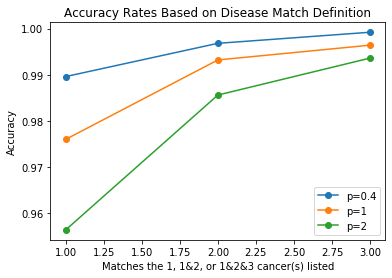

In [16]:
plt.plot([1, 2, 3], [0.989604, 0.996801, 0.999200], marker='o', label="p=0.4")
plt.plot([1, 2, 3], [0.976010, 0.993203, 0.996401], marker='o', label="p=1")
plt.plot([1, 2, 3], [0.956417, 0.985606, 0.993603], marker='o', label="p=2")
plt.xlabel("Matches the 1, 1&2, or 1&2&3 cancer(s) listed")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.title("Accuracy Rates Based on Disease Match Definition")
plt.show()

Now, to print all of them

p=0.3
Definitions of classification
Score of how many times the #1 diagnosed disease for each sample matches its true clinical label
Accuracy = 2461/2501 = 0.984006
Score of how many times the #1 or #2 diagnosed disease for each sample matches its true clinical label
Accuracy = (2461 + 30)/2501 = 0.996002
Score of how many times the #1,#2 or #3 diagnosed disease for each sample matches its true clinical label
Accuracy = (2461 + 30 + 8)/2501 = 0.999200
p=0.4
Definitions of classification
Score of how many times the #1 diagnosed disease for each sample matches its true clinical label
Accuracy = 2475/2501 = 0.989604
Score of how many times the #1 or #2 diagnosed disease for each sample matches its true clinical label
Accuracy = (2475 + 22)/2501 = 0.998401
Score of how many times the #1,#2 or #3 diagnosed disease for each sample matches its true clinical label
Accuracy = (2475 + 22 + 3)/2501 = 0.999600
p=0.5
Definitions of classification
Score of how many times the #1 diagnosed disease for

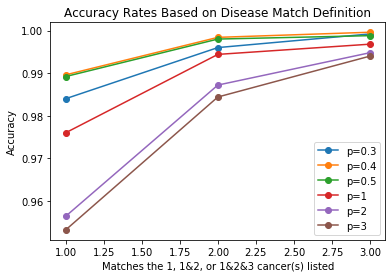

In [15]:
fig1, ax1 = plt.subplots()

for i in [0.3,0.4,0.5,1,2,3]:
    label = "p=" + str(i)
    print(label)
    ax1.plot([1, 2, 3], leave_one_out_multiple_definitions(i), marker='o', label=label)
ax1.set_xlabel("Matches the 1, 1&2, or 1&2&3 cancer(s) listed")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy Rates Based on Disease Match Definition")
ax1.legend(loc="lower right")
plt.show()

In [13]:
poo = leave_one_out_multiple_definitions(3)
print(poo)

Definitions of classification
Score of how many times the #1 diagnosed disease for each sample matches its true clinical label
Accuracy = 2384/2501 = 0.953219
Score of how many times the #1 or #2 diagnosed disease for each sample matches its true clinical label
Accuracy = (2384 + 78)/2501 = 0.984406
Score of how many times the #1,#2 or #3 diagnosed disease for each sample matches its true clinical label
Accuracy = (2384 + 78 + 24)/2501 = 0.994002
[0.953218712514994, 0.984406237504998, 0.9940023990403839]


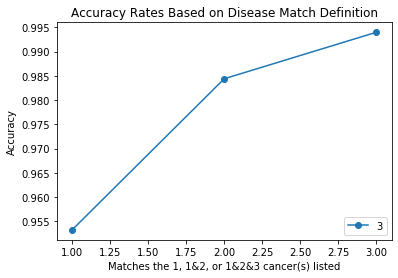

In [14]:
fig1, ax1 = plt.subplots()

ax1.plot([1, 2, 3], poo, marker='o', label="3")
ax1.set_xlabel("Matches the 1, 1&2, or 1&2&3 cancer(s) listed")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy Rates Based on Disease Match Definition")
ax1.legend(loc="lower right")
plt.show()

### Conclusions for pattern matching:
From these results, we see that the distance metric in which p=0.4 gives us the highest accuracy when using the leave-one-out method for pattern matching with the top 1, 2, or 3 cancer predictions.


Now that we have a robust method, we can create a function that returns the top 3 most likley cancer predictions given one sample. Here, we don't know if the prediction is correct or not since we aren't given a corresponding label.

I will also submit this algorithm as a separate python file in my project submission.

In [175]:
#Given one sample, return the list of likeliest cancers
#since we don't need to worry about efficiency as much here, since we have only one sample to compare,
#we revert to the original method.

xdata = np.array(x_data)
ydata = np.array(y_data)

#the sample should be an array of length 1881, which is the feature size
def predict_cancer_type(sample):
    if(len(sample) != 1881):
        print("length of array should be 1881 features")
        return -1
    sample = np.array(sample)
    
    p = 0.4 #what kind of sensitivity for distance. 2 is euclidean distance
    
    #The Minkowski distance is a metric in a normed vector space which can be considered 
    # as a generalization of both the Euclidean distance (p=2) and the Manhattan distance (p=1).
    
    probs = { "lung": -1, "prostate":-1, "endometrial":-1,"colorectal":-1,"kidney":-1   }    
    
    for j in range(0,len(xdata)):
        y_current = y_data[j]
        #distance = minkowski_distance(sample, xdata[j], p)
        
        distance = np.sum(np.abs(sample - xdata[j])**p, axis=-1)
        if probs[y_current] == -1:
            probs[y_current] = distance
        elif distance < probs[y_current]:
            probs[y_current] = distance

    #sort the probabilities by smallest to largest
    #and only print out the top 3 likeliest 
    p_view = [ (v,k) for k,v in probs.items() ]
    p_view.sort(reverse=False) #sort tuples by first element
    #for v,k in p_view[0:3]:
    #    print("%s: %f" % (k,v))
    
    print("The top three cancer types closest to the given sample, in order from least to largest distance")
    print("1. %s" % p_view[0][1])
    print("2. %s" % p_view[1][1])
    print("3. %s" % p_view[2][1])
        
    return p_view[0:3]
        
predict_cancer_type(xdata[2])

The top three cancer types closest to the given sample, in order from least to largest distance
1. colorectal
2. kidney
3. endometrial


[(0.0, 'colorectal'),
 (1925.7228156665449, 'kidney'),
 (1995.5564545168077, 'endometrial')]

---

In the next section, I include some machine learning methods I used for my machine learning course final project at UCI. This can be compared to the leave one out method above. 

A little foreshadowing: The results do not surpass that of the pattern matcher.

Since this dataset has 5 labels, or 5 classes, it can be turned into a multiclass classification problem.

## Machine Learning


First, I split the data into training and testing sets.

Then I use the following algorithms for multiclass classifiction:
- K nearest neighbors
- Decision tree
- Random Forest


In [196]:
#split test and training data
msk = np.random.rand(len(x_data.values)) < 0.8
x_train = x_data[msk]
x_test = x_data[~msk]

y_train = y_data[msk]
y_test = y_data[~msk]

print("Training Shape")
print(x_train.shape)
print(y_train.shape)
#print(x_train.iloc[[0]])

print("Testing Shape")
print(x_test.shape)
print(y_test.shape)
#print(x_test.iloc[[0]])

class_names = list(set(y_data))
print(class_names)

Training Shape
(2006, 1881)
(2006,)
Testing Shape
(495, 1881)
(495,)
['prostate', 'colorectal', 'lung', 'endometrial', 'kidney']


---
### K Nearest Neighbors

k nearest neighbors since that is good for multiclass classification

In [199]:
#default number of neighbors is 5
#default distance metric is metric=’minkowski’
n=2

N = [1,2,3,4,5,10,15,20]
scores = []
training_scores = []

for n in N:
    print(n)
    knn = KNeighborsClassifier(n_neighbors=n, metric='minkowski')
    knn.fit(x_train, y_train) 
    
    #training error
    y_pred = knn.predict(x_train)
    accuracy = knn.score(x_train, y_train) #given x_test and the true labels for X
    print("Training accuracy: %f" % accuracy)
    training_scores.append([n,accuracy])    
    
    #test error
    y_pred = knn.predict(x_test)
    accuracy = knn.score(x_test, y_test) #given x_test and the true labels for X
    print("Testing accuracy: %f" % accuracy)
    scores.append([n,accuracy])
    

    

# Returns the mean accuracy on the given test data and labels
#In multi-label classification, this is the subset accuracy 
# which is a harsh metric since you require for each sample that each label set be correctly predicted.




1
Training accuracy: 1.000000
Testing accuracy: 0.933333
2
Training accuracy: 0.981555
Testing accuracy: 0.935354
3
Training accuracy: 0.976072
Testing accuracy: 0.939394
4
Training accuracy: 0.970090
Testing accuracy: 0.943434
5
Training accuracy: 0.966102
Testing accuracy: 0.933333
10
Training accuracy: 0.962114
Testing accuracy: 0.937374
15
Training accuracy: 0.950648
Testing accuracy: 0.925253
20
Training accuracy: 0.938684
Testing accuracy: 0.925253


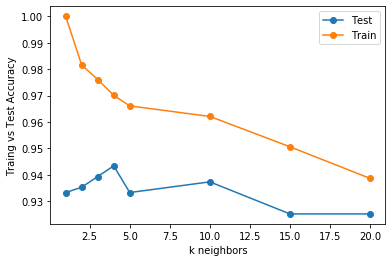

In [200]:
scores = np.array(scores)
training_scores = np.array(training_scores)
plt.plot(scores[:,0],scores[:,1], marker='o', label='Test')
plt.plot(training_scores[:,0],training_scores[:,1], marker='o', label='Train')
plt.legend(loc="upper right")
plt.xlabel("k neighbors")
plt.ylabel("Traing vs Test Accuracy")
plt.show()

### Tree Classifiers

Decision trees are great to study the effect the features have on classification. During training, the decision tree algorithm builds a tree based on rules that are like if else statements. In the end, we have a tree that from the top, you can ask it if the sample's feature is less than a certain value, you continue to the left of the tree, and so on until you reach a leaf node that determines the class of the sample. The higher the node on the tree, the more important it is in the decision making.

Test accuracy: 0.937736
Training accuracy: 1.000000


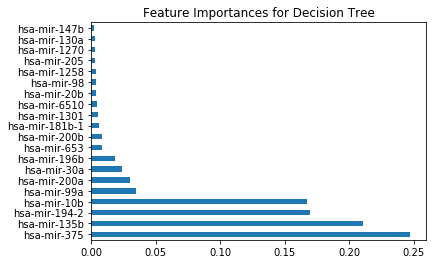

In [190]:
#
# Decision tree
#
tree_clf = tree.DecisionTreeClassifier()
tree_clf = tree_clf.fit(x_train, y_train)

#y_pred = tree_clf.predict(x_test)


tree_acc = tree.DecisionTreeClassifier.score(tree_clf, x_test, y_test)
print("Test accuracy: %f" % tree_acc)

#decision tree is perfect with the training data
tree_acc = tree.DecisionTreeClassifier.score(tree_clf, x_train, y_train)
print("Training accuracy: %f" % tree_acc)

tree_data = tree.export_graphviz(tree_clf,feature_names=x_train.columns,class_names=class_names)
#print(tree_data) 
#prints the tree in text format

feat_importances = pd.Series(tree_clf.feature_importances_, index=x_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title("Feature Importances for Decision Tree")
plt.show()

#graph = graphviz.Source(tree_data) 
#graph.render("decision_tree")

Without any modification, this decision tree has an okay test accuracy. Here, we see that the most important feature is hsa-mir-375. I omit the rest of the features in this resulting graph, since they were far less important in classification. Perhaps this lack of important features is related to the not-so-great accuracy rate.


Next I try Random Forest, since this algorithm is known to outperform Decision Tree by itself. We will see soon that it also outperforms it here as well.

In [192]:
#
# Random Forest
#

#default parameters: max_depth=2, random_state=0, estimators=100

clf_rand = RandomForestClassifier(max_depth=None,random_state=0, n_estimators=100) 
clf_rand.fit(x_train, y_train)
#RandomForestClassifier(max_depth=2, random_state=0)

#print(clf_rand.predict(x_test))

acc_rand = RandomForestClassifier.score(clf_rand,x_test,y_test)
print("Testing Accuracy: %f" % acc_rand)


print("Training Accuracy: %f" % RandomForestClassifier.score(clf_rand,x_train,y_train))
#Return the mean accuracy on the given test data and labels.
#In multi-label classification, this is the subset accuracy which is a harsh metric since you 
#require for each sample that each label set be correctly predicted.



Testing Accuracy: 0.983019
Training Accuracy: 1.000000


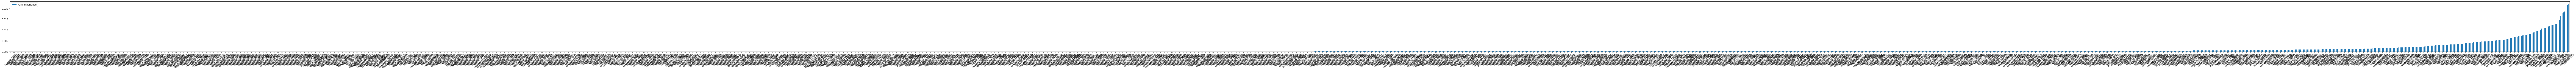

In [191]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x_train.columns, clf_rand.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances_all = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances_all.sort_values(by='Gini-importance').plot(kind='bar', rot=45, figsize=(200, 4))
plt.show()

#These are all of the feature importances. Double click on the image to zoom in.
#  Most are rather insignificant so we omit them next

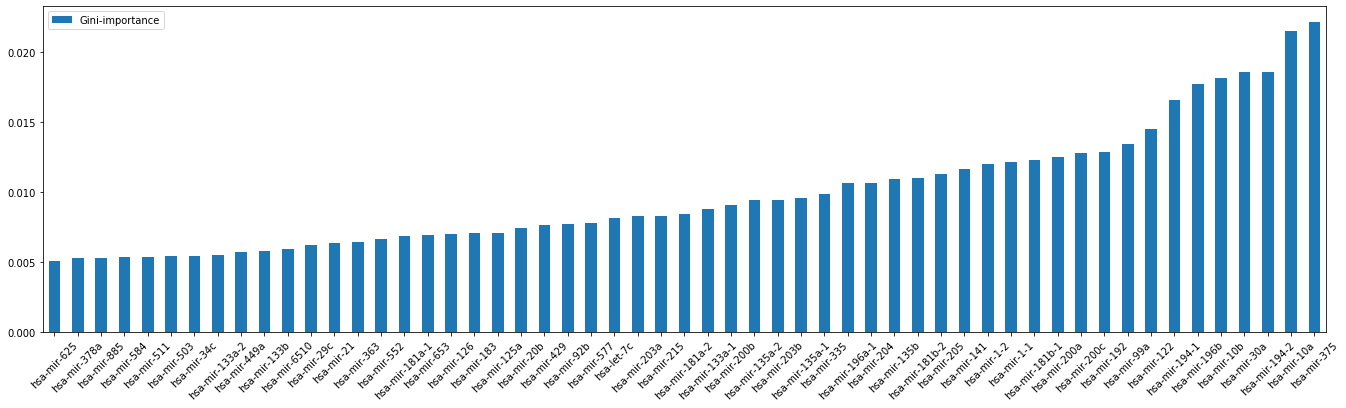

In [142]:
#remove features where the importance is tiny. < 0.00001 so that we can see the most important ones

feats_short = {i:feats[i] for i in feats if feats[i] > 0.005}
importances = pd.DataFrame.from_dict(feats_short, orient='index').rename(columns={0: 'Gini-importance'})

importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45, figsize=(23, 6))
plt.show()

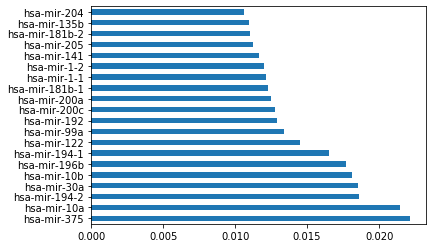

In [150]:
#here's an easier to read version:

feat_importances = pd.Series(clf_rand.feature_importances_, index=x_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

These graphs show us that there are more features used in this algorithm that are important to the decision making process. This likely leads to the higher accuracy rate than decision tree. 

If I knew more about microRNA, I would do more analysis of the features in relation to the cancer types, but I will leave that to the experts.